In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [3]:
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'

In [4]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

#### feature folder

In [6]:
CUR_PATH= os.path.abspath("__file__")
GAZE_FEATURE_FOLDER = os.path.join(get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
HAND_FEATURE_FOLDER = os.path.join(get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'features')
HAND_PSYCHOPY_FOLDER = os.path.join(get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'psychopy')

In [7]:
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [15]:
import json

def normalize_features(features):
    # Z-score normalization
    means = np.mean(features, axis=0)  # Mean of each column
    stds = np.std(features, axis=0)    # Standard deviation of each column
    features = (features - means) / (stds + 1e-5)
    # clap to remove outlier
    clip_range = 5 
    features = np.clip(features, -clip_range, clip_range)
    # convert all to non-negative
    features = (features + clip_range) / (2 * clip_range)
    return features

def load_raw_gaze_features(subj, time_steps):
    feature_loaded = []
    subj_result_folder = os.path.join(GAZE_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))
    return features, behavior_data

def load_raw_hand_features(subj, time_steps):
    subj_feature_path = os.path.join(HAND_FEATURE_FOLDER, '1d', f'{subj}.npy')
    features = np.load(subj_feature_path)
    features = features[:, time_steps]
    features = np.mean(features, axis=1)

    behavior_data = pd.read_csv(os.path.join(HAND_PSYCHOPY_FOLDER, f'{subj}.csv'))

    return features, behavior_data

def load_subj_features(subj, feature_type, time_steps, normalize=True):
    if feature_type == 'gaze':
        features, behavior_data = load_raw_gaze_features(subj, time_steps)
    elif feature_type == 'hand':
        features, behavior_data = load_raw_hand_features(subj, time_steps)
    
    if normalize:
        features = normalize_features(features)

    return features, behavior_data


In [9]:
DELAY_TIME = [4500, 9500]
timebin = 50
delay_time_points = np.arange(
    np.ceil(DELAY_TIME[0] / timebin + 0.5),
    np.floor(DELAY_TIME[1] / timebin - 0.5) + 1).astype(int)

In [10]:
example_features, example_df = load_subj_features(
    916, 'gaze', time_steps=delay_time_points, normalize=True)

### Display features from specific trial

In [71]:
from utils.inverted_encoding import deg_signed_diff
from utils.feature_plotting import (
    plot_single_1d_gaze,
    plot_single_1d_plot_vectors
)

from scipy.ndimage import zoom

def plot_mean_gaze(ax, x, y):
    ax.scatter(x, y, s=600, color='purple', marker='*')
    # ax.scatter(0, 0, s=150, color='gray', marker='P')
    ax.text(
        0, 0, '+', ha='center', va='center',
        fontsize=40, color='gray')
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])

def plot_blurred_img(ax, features, original_w, ratio):
    img = features.reshape((original_w, original_w))
    img = zoom(img, [ratio, ratio], order=1)
    ax.imshow(img, cmap='coolwarm', origin='lower')

def display_hand_features(features):
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.axis('off')
    ax.set_aspect('equal')
    plot_single_1d_plot_vectors(
        features, angle=None, ax=ax, set_title=False)

def display_gaze_features(features):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    ax = axs[0]
    plot_mean_gaze(ax, features[0], features[1])

    ax = axs[1]
    plot_features = features[2:32]
    plot_features = plot_features - np.mean(plot_features)
    plot_single_1d_gaze(
        plot_features, angle=None, ax=ax, set_title=False)

    ax = axs[2]
    plot_features = features[32:]
    plot_features = plot_features - np.mean(plot_features)
    plot_blurred_img(ax, plot_features, original_w=15, ratio=0.4)

def display_example_features(subj, target_stim, time_steps, feature_type):
    features, df = load_subj_features(
        subj, feature_type, time_steps, normalize=True)

    # only valid trial
    valid_mask = (~(df['resp_1'].isna())).values
    features = features[valid_mask]
    df = df[valid_mask]
    
    # find good trial
    errors = deg_signed_diff(df['resp_1']-df['stim_1']).abs().values.astype(int)
    goood_trial_mask = errors < 10
    features = features[goood_trial_mask]
    df = df[goood_trial_mask]

    # find the one match the target stim best
    target_match_errs = deg_signed_diff(df['stim_1'] - target_stim).abs().values
    target_k = np.argmin(target_match_errs)
    target_feature = features[target_k]
    target_trial_info = df.iloc[target_k]

    print(f'stim: {target_trial_info["stim_1"]:.1f}, trial id: {target_trial_info["TRIALID"]}')

    if feature_type == 'gaze':
        display_gaze_features(target_feature)
    elif feature_type == 'hand':
        display_hand_features(target_feature)
    else:
        raise ValueError(f'Unknown feature type: {feature_type}')


stim: 59.2, trial id: ('916', 8, 3)


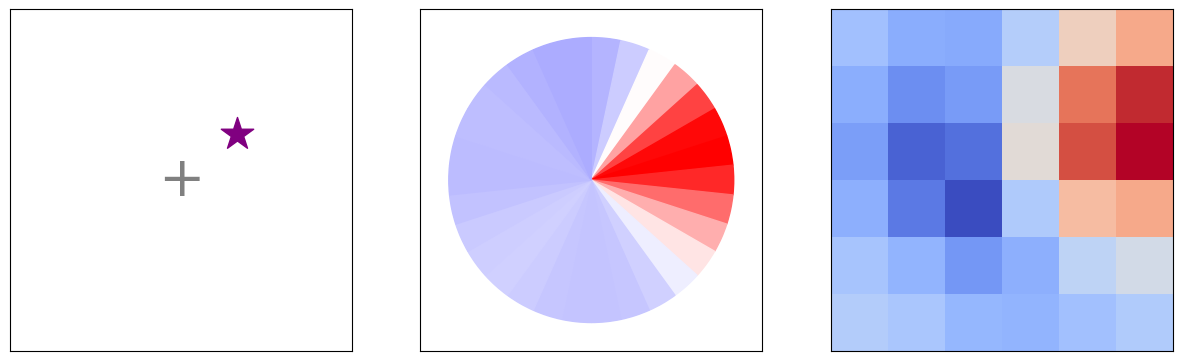

In [72]:
display_example_features(916, 60, delay_time_points, 'gaze')

stim: 118.1, trial id: ('917', 8, 13)


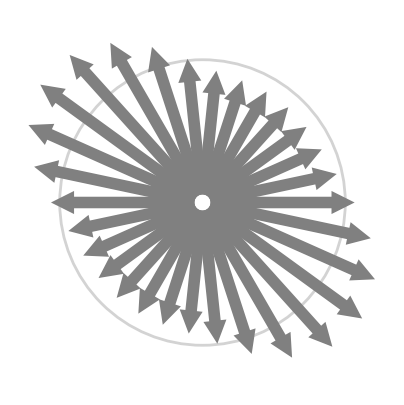

In [25]:
display_example_features(917, 120, delay_time_points, 'hand')

### Now check the raw features

In [ ]:
DATA_FOLDER = os.path.join(get_n_dir_up(CUR_PATH, 3), 'data')
DATA_LARGE_FOLDER = os.path.join(get_n_dir_up(CUR_PATH, 4), 'data', 'pilot')
DEFAULT_BEHAV_FOLDER = os.path.join(DATA_FOLDER, 'behavior', 'subjects')
DEFAULT_GAZE_FOLDER = os.path.join(DATA_LARGE_FOLDER, 'gaze')

In [84]:
TARGET_TRIALS = ["('916', 8, 3)", "('917', 8, 13)"]

In [92]:
from utils.eye_data import create_xydata_from_df

def read_cleaned_gaze_data(behavior_folder, gaze_folder, filename='916to922'):
    psyFull_path = f'{behavior_folder}/{filename}.csv'
    psyFull = None
    if os.path.exists(psyFull_path):
        psyFull = pd.read_csv(psyFull_path)
        psyFull = psyFull.drop(
            columns=[col for col in psyFull.columns if col.startswith("Unnamed")])
        
    gazeClean_path = f'{gaze_folder}/{filename}.csv'
    gazeClean = None
    if os.path.exists(gazeClean_path):
        gazeClean = pd.read_csv(gazeClean_path)
        gazeClean = gazeClean.drop(
            columns=[col for col in gazeClean.columns if col.startswith("Unnamed")])

    return psyFull, gazeClean

def load_subj_gaze_raw_data(target_trials=TARGET_TRIALS):
    psyFull, gaze_df = read_cleaned_gaze_data(
        DEFAULT_BEHAV_FOLDER, DEFAULT_GAZE_FOLDER)
    eye_data = create_xydata_from_df(gaze_df)
    # print(eye_data.trial_ids)
    trial_gaze = eye_data.read_phase(
        phases=[DELAY_TIME,], trial_ids=target_trials)
    return trial_gaze

In [93]:
target_gaze_xs, target_gaze_ys = load_subj_gaze_raw_data()

#### Load subject overall mean

In [125]:
def plot_raw_gaze(xs, ys, zoom_ratio=1):
    fig, ax = plt.subplots(1, figsize=(8, 4.5))
    fig.patch.set_facecolor('gray')
    ax.set_aspect('equal')
    ax.axis('off')

    # apply the mask we use for feature extraction
    xlims = 960 + np.array([-1, 1]) * 960 * zoom_ratio
    ylims = 540 + np.array([-1, 1]) * 540 * zoom_ratio
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.text(
        960, 540, '+', ha='center', va='center',
        fontsize=40, color='red')

    # those in valid 
    ax.scatter(xs, ys, color='white', edgecolor='gray', alpha=0.4)

    return ax

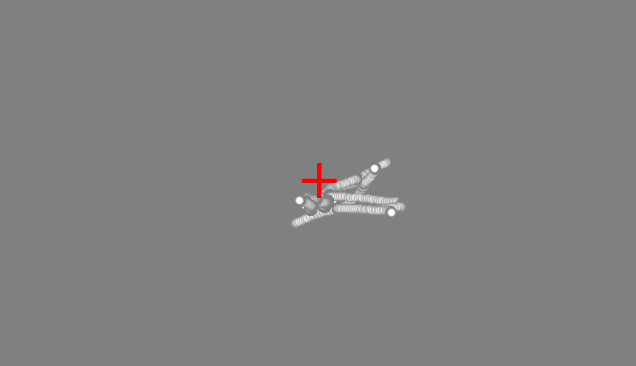

In [126]:
ax = plot_raw_gaze(target_gaze_xs, target_gaze_ys)

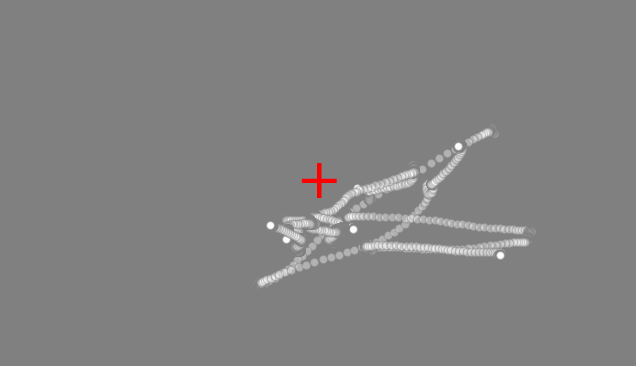

In [130]:
ax = plot_raw_gaze(target_gaze_xs, target_gaze_ys, zoom_ratio=0.4)

In [132]:
def load_phase_mean_gaze(subj, phases):
    unnormalized_mean_name = 'GazeMeanExtractor_297c84'
    cur_unnorm_path = os.path.join(GAZE_FEATURE_FOLDER, subj, unnormalized_mean_name)
    features = np.load(os.path.join(cur_unnorm_path, f'features.npy'))

    mean_x = np.mean(features[:, phases, 0])
    mean_y = np.mean(features[:, phases, 1])

    return mean_x*960 + 960, mean_y*540 + 540

In [133]:
subj_gaze_mean_x, subj_gaze_mean_y = load_phase_mean_gaze('916', delay_time_points)

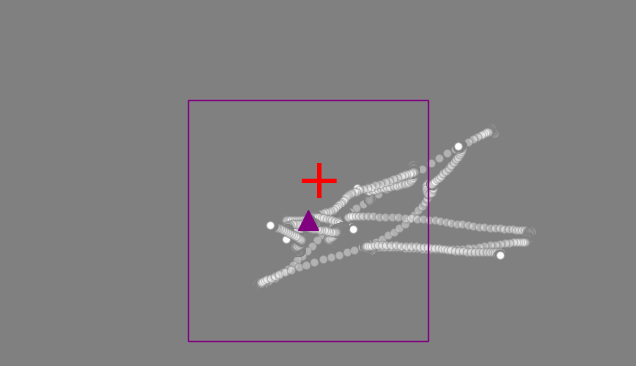

In [137]:
import matplotlib.patches as patches

ax = plot_raw_gaze(target_gaze_xs, target_gaze_ys, zoom_ratio=0.4)
ax.scatter(subj_gaze_mean_x, subj_gaze_mean_y, s=200, color='purple', marker='^')
rect = patches.Rectangle(
    (subj_gaze_mean_x - 150, subj_gaze_mean_y - 150),
    300, 300, 
    edgecolor='purple',
    facecolor='none'
)
ax.add_patch(rect)
